# Análisis Exploratorio de Datos - Mercado Inmobiliario

Este cuaderno realiza la limpieza, análisis exploratorio y regresion lineal de los datos scrapeados de ZonaProp.

## 0. Imports

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import geopandas as gpd
import unicodedata
import matplotlib.patheffects as pe

# Configuración de estilo
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.2f}'.format

## 1. Carga de Datos
En esta sección cargaremos los datos desde el archivo CSV.

In [21]:
# Leemos el dataset
try:
    df = pd.read_csv("../data/raw/real_estate_listings.csv")
    print(f"Dimensiones iniciales: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print("Archivo no encontrado. Verifica la ruta.")

Dimensiones iniciales: (76000, 6)


,price,location,features,expensas,description,url
0,USD 82.000,"Parque Patricios, Capital Federal","['60 m² tot.', '3 amb.', '2 dorm.', '1 baño']",$ 31.000 Expensas,Semipiso 3 ambientes. Contrafrente. 60 M2. Impecable. Vista abierta. Todo sol. Baño completo. Amplia cocina. Servicios individuales. Lavadero incorporado. Pisos de parquet. Carpinterias de cedro. Edif,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-semip-en-monteagudo-al-200-60-m-sup2--impecable-56721068.html?n_src=Listado&n_pills=Apto+cr%C3%A9dito&n_pg=1&n_pos=1
1,USD 110.000,"Constitución, Capital Federal","['81 m² tot.', '4 amb.', '3 dorm.', '2 baños']",$ 153.000 Expensas,"Excelente departamento de 4 ambientes al frente. En luminoso 8vo. Piso con vista abierta, sobre Bernardo de Irigoyen a metros de Av. Garay. - 81m2 cubiertos. - Amplio living comedor con ventanal al fr",https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-4-amb-vista-abierta-constitucion-57277541.html?n_src=Listado&n_pills=Apto+cr%C3%A9dito&n_pg=1&n_pos=2
2,USD 59.900,"Palermo, Capital Federal","['35 m² tot.', '1 amb.', '1 baño']",$ 70.000 Expensas,"Corredor Responsable: power bienes raíces S. R. L. - Sabrina Cocconi cpi 6800 / cmcpsi 6258- Contacto: Natalia Gonzalez Codino. Venta Monoambiente – Barrio Norte – Zona Facultades 34, 87 m² Totales. U",https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-departamento-monoambiente-venta-barrio-norte-58084728.html?n_src=Listado&n_pg=1&n_pos=3
3,USD 93.400,"Villa Devoto, Capital Federal","['32 un.', '1 a 2 amb.', '32 a 52 m² tot.', 'Parrilla', 'Solarium']",NaN,"• Comercializa bioi, una firma de Grupo Nocito• Beiró 3402 es un proyecto moderno de la firma bioi que combina confort y funcionalidad en una ubicación privilegiada. El edificio ofrecerá unidades de 1",https://www.zonaprop.com.ar/propiedades/emprendimiento/ememvein-deptos-en-pozo-1-y-2-amb-devoto-bioi-57240662.html?n_src=Listado&n_pg=1&n_pos=4
4,USD 295.000,"Belgrano, Capital Federal","['90 m² tot.', '4 amb.', '3 dorm.', '2 baños', '1 coch.']",$ 350.000 Expensas,"_ Departamento de tres dormitorios en venta ubicado sobre calle Vuelta de Obligado y Avenida Monroe (Belgrano, Ciudad Autónoma de Buenos Aires). Desarrollado en piso alto por ascensor, con disposición",https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-departamento-en-venta-3-dorm.-2-banos-belgrano-58099989.html?n_src=Listado&n_pills=Luminoso&n_pg=1&n_pos=5


## 1.1 Carga de Datos Geográficos (CABA Barrios)
Cargamos los datos de los barrios de CABA para análisis espacial.

In [22]:
# Cargar GeoJSON de barrios
url_geojson = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson"
try:
    barrios_caba = gpd.read_file(url_geojson)
    print("Barrios cargados correctamente.")
except Exception as e:
    print(f"Error al cargar barrios: {e}")


Barrios cargados correctamente.


## 2. Limpieza y Procesamiento de Datos
En esta sección limpiaremos y procesaremos los datos para poder utilizarlos de forma apropiada.

In [23]:
# 1. Limpieza de strings
df['features_clean'] = df['features'].str.replace(r"[[\]']", "", regex=True)
# Aseguramos que la descripcion sea string para evitar errores con nulos
df['description'] = df['description'].fillna('')

# 2. Función de extracción general
def extract_opt(text, pattern):
    match = re.search(fr'(\d+)\s*(?:{pattern})', text, re.IGNORECASE)
    return int(match.group(1)) if match else 0

# 3. Extracción de features 
df['m2'] = df['features_clean'].apply(lambda x: extract_opt(x, 'm²|metros'))
df['ambientes'] = df['features_clean'].apply(lambda x: extract_opt(x, 'amb'))
df['baños'] = df['features_clean'].apply(lambda x: extract_opt(x, 'baños'))
df['dormitorios'] = df['features_clean'].apply(lambda x: extract_opt(x, 'dorm'))
df['cocheras'] = df['features_clean'].apply(lambda x: extract_opt(x, 'coch'))

# 4. Limpieza de precio 
df['precio_usd'] = pd.to_numeric(df['price'].str.replace(r'[^0-9]', '', regex=True), errors='coerce')

# 5. Filtrado y Limpieza Final
df_clean = df.dropna(subset=['precio_usd']).copy()
df_clean['ubicación'] = df_clean['location']

df_clean['baños'] = df_clean['baños'].replace(0,1)

cols_finales = ['precio_usd', 'ubicación', 'm2', 'ambientes', 'dormitorios', 'baños', 'cocheras', 'url']
df_clean = df_clean[cols_finales].fillna(0)

df_clean.head()

,precio_usd,ubicación,m2,ambientes,dormitorios,baños,cocheras,url
0,82000.00,"Parque Patricios, Capital Federal",60,3,2,1,0,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-semip-en-monteagudo-al-200-60-m-sup2--impecable-56721068.html?n_src=Listado&n_pills=Apto+cr%C3%A9dito&n_pg=1&n_pos=1
1,110000.00,"Constitución, Capital Federal",81,4,3,2,0,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-4-amb-vista-abierta-constitucion-57277541.html?n_src=Listado&n_pills=Apto+cr%C3%A9dito&n_pg=1&n_pos=2
2,59900.00,"Palermo, Capital Federal",35,1,0,1,0,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-departamento-monoambiente-venta-barrio-norte-58084728.html?n_src=Listado&n_pg=1&n_pos=3
3,93400.00,"Villa Devoto, Capital Federal",52,2,0,1,0,https://www.zonaprop.com.ar/propiedades/emprendimiento/ememvein-deptos-en-pozo-1-y-2-amb-devoto-bioi-57240662.html?n_src=Listado&n_pg=1&n_pos=4
4,295000.00,"Belgrano, Capital Federal",90,4,3,2,1,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-departamento-en-venta-3-dorm.-2-banos-belgrano-58099989.html?n_src=Listado&n_pills=Luminoso&n_pg=1&n_pos=5


## 3. Análisis Exploratorio de Datos (EDA)
En esta sección generaremos nuevas variables y realizaremos un análisis exhaustivo de los datos inmobiliarios.

In [24]:
# 1. Creación de nuevas variables

# Precio por m2 (Dólares / m2)
df_clean = df_clean[df_clean['m2'] > 0].copy()
df_clean['precio_m2'] = df_clean['precio_usd'] / df_clean['m2']

# Relación cantidad de ambientes por m2
df_clean['ambientes_m2'] = df_clean['ambientes'] / df_clean['m2']

# Extracción del nombre del Barrio desde la columna 'ubicación'
df_clean['barrio'] = df_clean['ubicación'].apply(lambda x: x.split(',')[0].strip() if isinstance(x, str) else 'Desconocido')

print(f"Cantidad de barrios identificados: {df_clean['barrio'].nunique()}")
print("Variables creadas: precio_m2, ambientes_m2, barrio")
display(df_clean[['ubicación', 'barrio', 'precio_usd', 'm2', 'precio_m2']].head())

Cantidad de barrios identificados: 81
Variables creadas: precio_m2, ambientes_m2, barrio


,ubicación,barrio,precio_usd,m2,precio_m2
0,"Parque Patricios, Capital Federal",Parque Patricios,82000.00,60,1366.67
1,"Constitución, Capital Federal",Constitución,110000.00,81,1358.02
2,"Palermo, Capital Federal",Palermo,59900.00,35,1711.43
3,"Villa Devoto, Capital Federal",Villa Devoto,93400.00,52,1796.15
4,"Belgrano, Capital Federal",Belgrano,295000.00,90,3277.78


### 3.1 Identificación de Valores Atípicos (Outliers)
Visualizamos la distribución de las variables clave para detectar valores extremos que puedan sesgar el análisis.

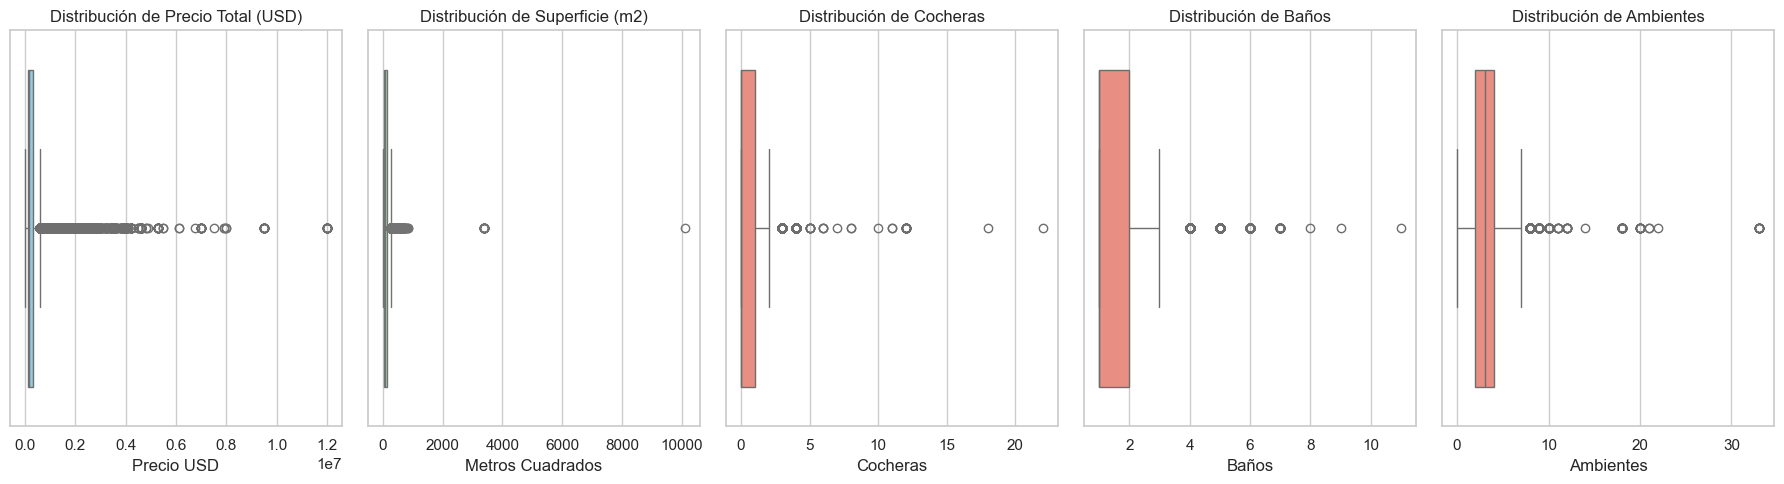

In [25]:
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

# Boxplot Precio Total
sns.boxplot(x=df_clean['precio_usd'], ax=axes[0], color='skyblue')
axes[0].set_title('Distribución de Precio Total (USD)')
axes[0].set_xlabel('Precio USD')

# Boxplot Superficie
sns.boxplot(x=df_clean['m2'], ax=axes[1], color='lightgreen')
axes[1].set_title('Distribución de Superficie (m2)')
axes[1].set_xlabel('Metros Cuadrados')

# Boxplot Cocheras
sns.boxplot(x=df_clean['cocheras'], ax=axes[2], color='salmon')
axes[2].set_title('Distribución de Cocheras')
axes[2].set_xlabel('Cocheras')

# Boxplot Baños
sns.boxplot(x=df_clean['baños'], ax=axes[3], color='salmon')
axes[3].set_title('Distribución de Baños')
axes[3].set_xlabel('Baños')

# Boxplot Ambientes
sns.boxplot(x=df_clean['ambientes'], ax=axes[4], color='salmon')
axes[4].set_title('Distribución de Ambientes')
axes[4].set_xlabel('Ambientes')

plt.tight_layout()
plt.show()


### 3.2 Limpieza de Outliers

Se identificaron 130 propiedades como outliers extremos.


,precio_usd,ubicación,m2,ambientes,dormitorios,baños,cocheras,url,precio_m2,ambientes_m2,barrio
334,140896.00,"Caballito, Capital Federal",50,2,1,11,0,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-departamento-en-venta-en-caballito-57260096.html?n_src=Listado&n_pills=Dormitorio+en+suite&n_pg=12&n_pos=5,2817.92,0.04,Caballito
389,530000.00,"Palermo, Capital Federal",117,4,3,3,11,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-nuevo-ingreso-palermo-view-58092075.html?n_src=Listado&n_pills=SUM&n_pg=13&n_pos=30,4529.91,0.03,Palermo
619,11000.00,"Saavedra, Capital Federal",86,3,0,1,0,https://www.zonaprop.com.ar/propiedades/emprendimiento/ememvein-vedia-4755-bleecker-departamentos-de-1-2-y-3-54146193.html?n_src=Listado&n_pg=21&n_pos=20,127.91,0.03,Saavedra
1669,11000.00,"Saavedra, Capital Federal",86,3,0,1,0,https://www.zonaprop.com.ar/propiedades/emprendimiento/ememvein-vedia-4755-bleecker-departamentos-de-1-2-y-3-54146193.html?n_src=Listado&n_pg=56&n_pos=20,127.91,0.03,Saavedra
2291,15000.00,"Villa del Parque, Capital Federal",80,3,0,1,0,https://www.zonaprop.com.ar/propiedades/emprendimiento/ememvein-sm-4820-54795693.html?n_src=Listado&n_pg=77&n_pos=12,187.50,0.04,Villa del Parque
3234,205000.00,"Recoleta, Capital Federal",54,21,1,1,0,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-monoambiente-venta-54-m-sup2--torre-iq-callao-57934624.html?n_src=Listado&n_pills=Terraza&n_pg=108&n_pos=25,3796.30,0.39,Recoleta
3934,12000000.00,"Belgrano, Capital Federal",3367,8,4,4,12,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-departamento-piso-en-venta-ubicado-en-belgrano-57986369.html?n_src=Listado&n_pills=Parrilla&n_pg=132&n_pos=5,3564.00,0.00,Belgrano
4252,11.00,"Caballito, Capital Federal",129,4,3,2,2,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-departamento-4-amb.-en-caballito-excelente-56953623.html?n_src=Listado&n_pills=Dormitorio+en+suite&n_pg=142&n_pos=23,0.09,0.03,Caballito
6405,225900.00,"Otro, Capital Federal",185,4,0,1,0,https://www.zonaprop.com.ar/propiedades/emprendimiento/ememhoin-terrazas-al-delta-57968255.html?n_src=Listado&n_pg=214&n_pos=16,1221.08,0.02,Otro
7537,1.00,"Villa del Parque, Capital Federal",117,3,0,1,0,https://www.zonaprop.com.ar/propiedades/emprendimiento/ememvein-beysan-tower-55081774.html?n_src=Listado&n_pg=252&n_pos=8,0.01,0.03,Villa del Parque


https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-departamento-en-venta-en-caballito-57260096.html?n_src=Listado&n_pills=Dormitorio+en+suite&n_pg=12&n_pos=5
https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-nuevo-ingreso-palermo-view-58092075.html?n_src=Listado&n_pills=SUM&n_pg=13&n_pos=30
https://www.zonaprop.com.ar/propiedades/emprendimiento/ememvein-vedia-4755-bleecker-departamentos-de-1-2-y-3-54146193.html?n_src=Listado&n_pg=21&n_pos=20
https://www.zonaprop.com.ar/propiedades/emprendimiento/ememvein-vedia-4755-bleecker-departamentos-de-1-2-y-3-54146193.html?n_src=Listado&n_pg=56&n_pos=20
https://www.zonaprop.com.ar/propiedades/emprendimiento/ememvein-sm-4820-54795693.html?n_src=Listado&n_pg=77&n_pos=12
https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-monoambiente-venta-54-m-sup2--torre-iq-callao-57934624.html?n_src=Listado&n_pills=Terraza&n_pg=108&n_pos=25
https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-departamento-piso-en-venta-ubica

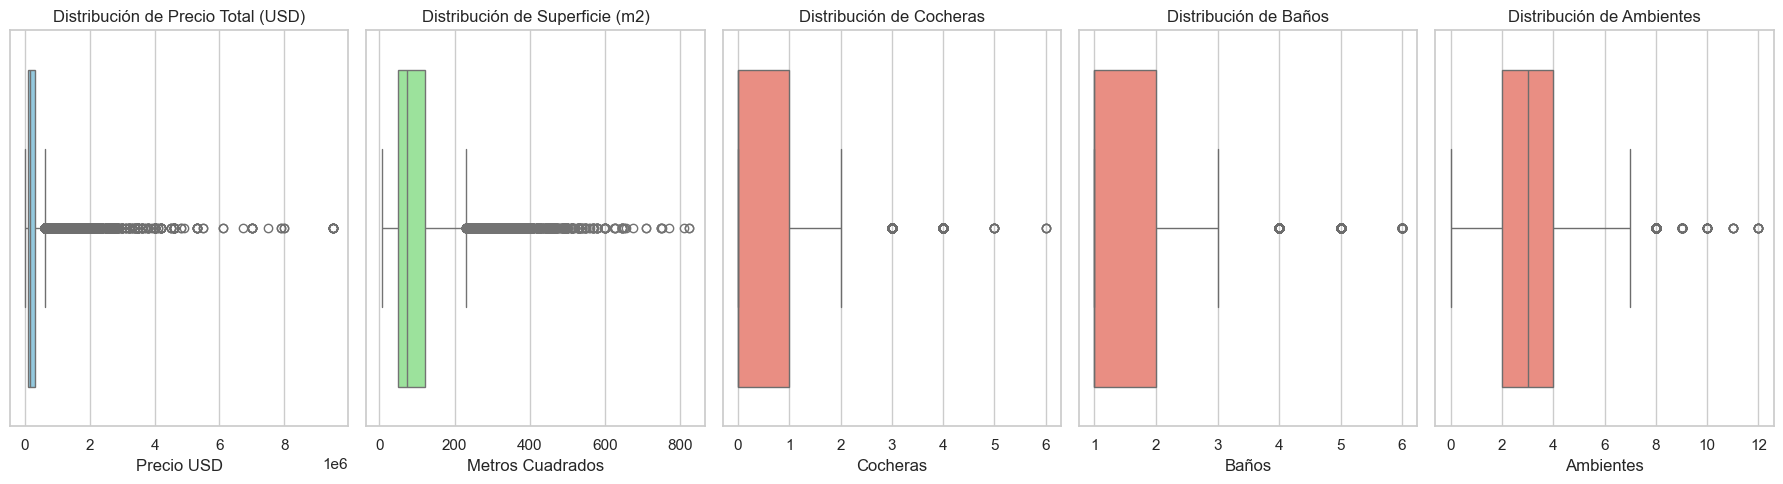

In [26]:
# Identificar Outliers
# Creamos un filtro para identificar outliers
filtro_outliers = (
    (df_clean['precio_usd'] < 20000) |  
    (df_clean['m2'] > 5000) | 
    (df_clean['cocheras'] > 6) | 
    (df_clean['baños'] > 6) | 
    (df_clean['ambientes'] > 12) | 
    (df_clean['barrio'] == 'Otro')
    )

df_outliers = df_clean[filtro_outliers]

print(f"Se identificaron {len(df_outliers)} propiedades como outliers extremos.")
display(df_outliers.head(10))

# Extraer urls
urls_outliers = df_outliers['url']
for url in urls_outliers:
    print(url)

# Eliminar outliers
df_clean = df_clean.drop(df_outliers.index)

# Eliminar duplicados
# Eliminar duplicados (por URL, no por precio/m2 que causa pérdida de datos)
if 'url' in df_clean.columns:
    df_clean = df_clean.drop_duplicates(subset=['url'], keep='first')
else:
    df_clean = df_clean.drop_duplicates(keep='first')

# Comprobación
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

# Boxplot Precio Total
sns.boxplot(x=df_clean['precio_usd'], ax=axes[0], color='skyblue')
axes[0].set_title('Distribución de Precio Total (USD)')
axes[0].set_xlabel('Precio USD')

# Boxplot Superficie
sns.boxplot(x=df_clean['m2'], ax=axes[1], color='lightgreen')
axes[1].set_title('Distribución de Superficie (m2)')
axes[1].set_xlabel('Metros Cuadrados')

# Boxplot Cocheras
sns.boxplot(x=df_clean['cocheras'], ax=axes[2], color='salmon')
axes[2].set_title('Distribución de Cocheras')
axes[2].set_xlabel('Cocheras')

# Boxplot Baños
sns.boxplot(x=df_clean['baños'], ax=axes[3], color='salmon')
axes[3].set_title('Distribución de Baños')
axes[3].set_xlabel('Baños')

# Boxplot Ambientes
sns.boxplot(x=df_clean['ambientes'], ax=axes[4], color='salmon')
axes[4].set_title('Distribución de Ambientes')
axes[4].set_xlabel('Ambientes')

plt.tight_layout()
plt.show()


### 3.3 Segmentación Geográfica
Analizamos el precio promedio y el valor del m² agrupados por barrio. Esto permite identificar zonas premium y oportunidades de inversión.

Top 10 Barrios más caros por m2:


,precio_usd,precio_m2,cantidad
barrio,,,
Puerto Madero,1005660.44,6071.29,1269
Palermo Nuevo,671825.13,4235.86,144
Palermo Chico,733019.75,4126.86,809
Barrio Parque,906000.00,3950.16,14
Lomas de Núñez,414257.62,3691.89,26
Belgrano Chico,412439.45,3690.35,42
Palermo Hollywood,265680.63,3472.54,1211
Las Cañitas,386208.89,3449.06,762
Núñez,392972.47,3400.31,1861


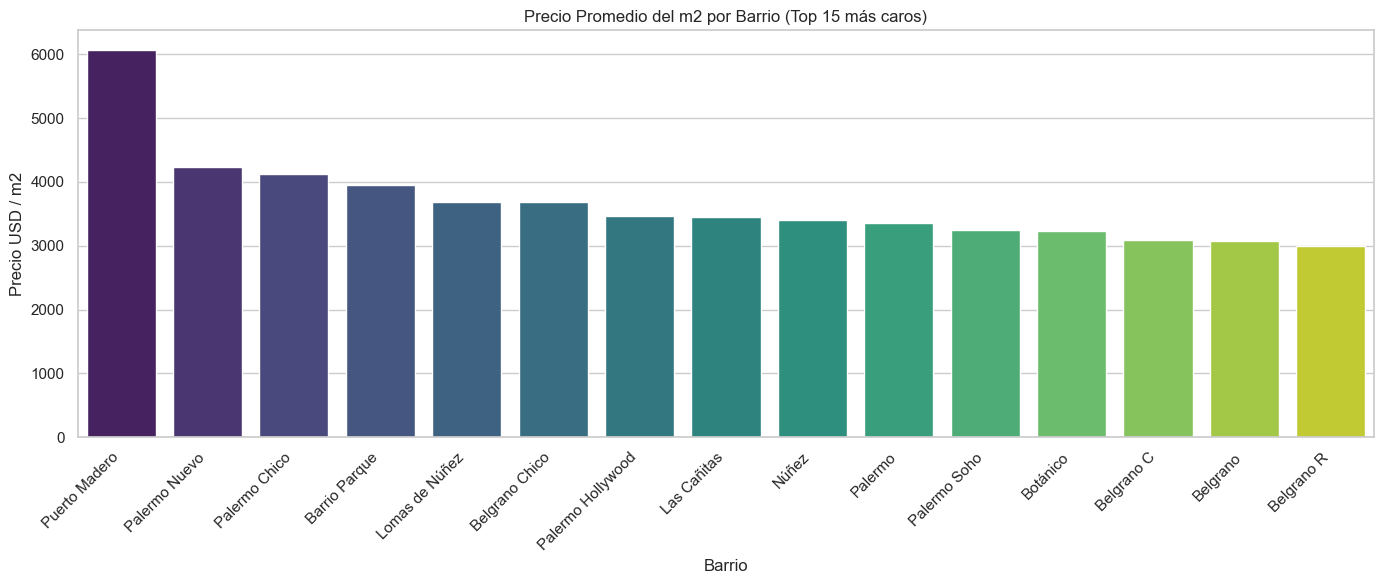

Top 10 Barrios más baratos por m2:


,precio_usd,precio_m2,cantidad
barrio,,,
Pompeya,51577.19,1144.44,57
Villa Soldati,66625.00,1153.94,8
Barracas,118618.32,1265.26,648
Tribunales,110095.74,1334.70,47
Congreso,94057.27,1335.33,245
Villa Lugano,96092.25,1441.48,89
Constitución,88307.99,1549.81,100
Once,102861.89,1571.38,74
Floresta,98419.82,1618.55,111


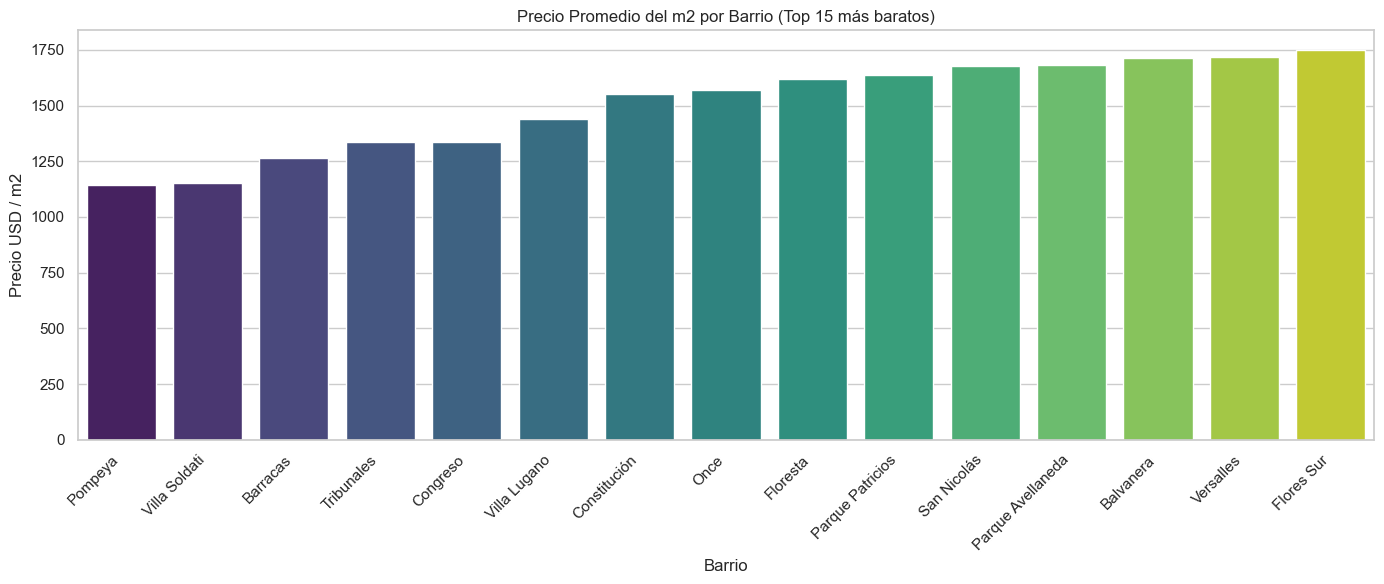

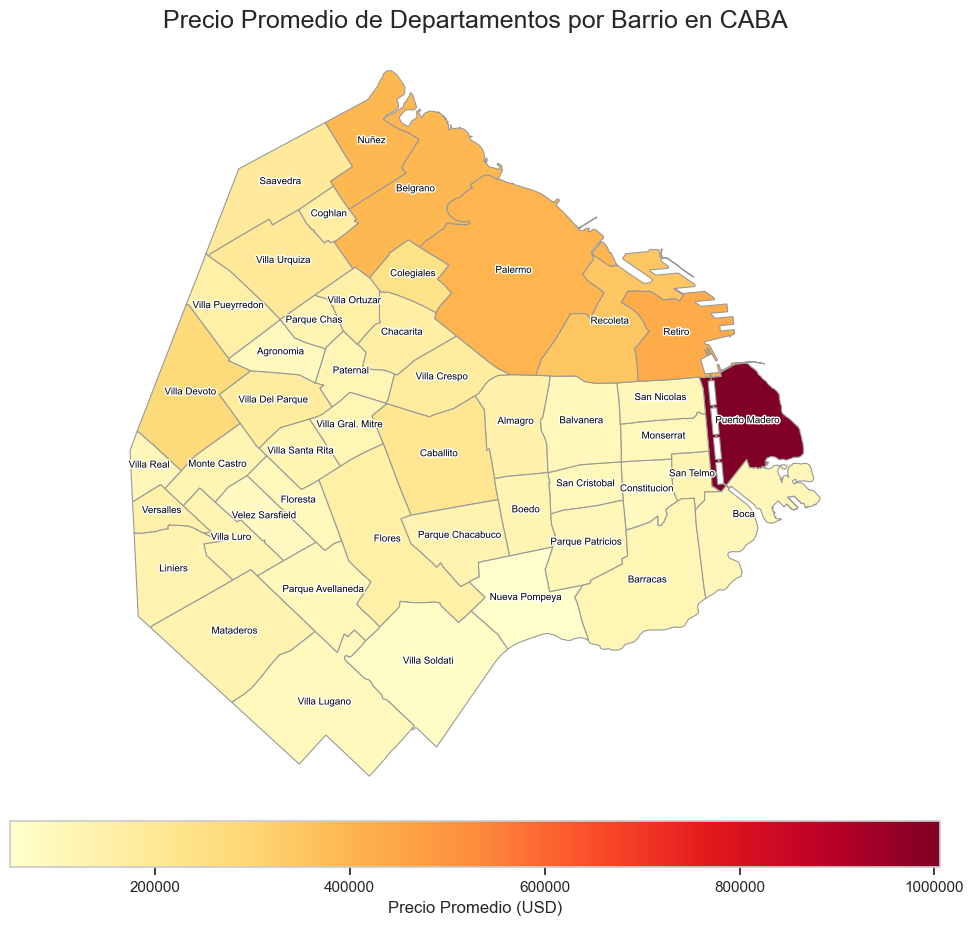

¡Todos los barrios mapeados correctamente!


In [42]:
# Agrupamos por barrio y calculamos medias
barrio_stats = df_clean.groupby('barrio').agg({
    'precio_usd': 'mean',
    'precio_m2': 'mean',
    'ubicación': 'count' 
}).rename(columns={'ubicación': 'cantidad'}).sort_values('precio_m2', ascending=False)

# Filtramos solo barrios con una cantidad mínima representativa de datos
barrio_stats = barrio_stats[barrio_stats['cantidad'] > 5]

print("Top 10 Barrios más caros por m2:")
display(barrio_stats.head(10))

# Visualización de los Top 15 Barrios por Precio m2
plt.figure(figsize=(14, 6))
top_barrios = barrio_stats.head(15)
sns.barplot(x=top_barrios.index, y=top_barrios['precio_m2'], hue=top_barrios.index, palette='viridis', legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Precio Promedio del m2 por Barrio (Top 15 más caros)')
plt.ylabel('Precio USD / m2')
plt.xlabel('Barrio')
plt.tight_layout()
plt.show()

print("Top 10 Barrios más baratos por m2:")
barrios_baratos = barrio_stats.sort_values('precio_m2', ascending=True).head(15)
display(barrios_baratos)

# Visualización de los Top 15 Barrios más baratos por Precio m2
plt.figure(figsize=(14, 6))
barrios_baratos.head(15)
sns.barplot(x=barrios_baratos.index, y=barrios_baratos['precio_m2'], hue=barrios_baratos.index, palette='viridis', legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Precio Promedio del m2 por Barrio (Top 15 más baratos)')
plt.ylabel('Precio USD / m2')
plt.xlabel('Barrio')
plt.tight_layout()
plt.show()

# Grafico Geografico Heatmap del precio promedio por barrio
def normalize_text(text):
    if not isinstance(text, str): return ""
    text = text.upper().strip()
    return ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

barrio_mapping = {
    'ABASTO': 'BALVANERA',
    'ALMAGRO NORTE': 'ALMAGRO',
    'ALMAGRO SUR': 'ALMAGRO',
    'BARRIO CHINO': 'BELGRANO',
    'BARRIO NORTE': 'RECOLETA',
    'BARRIO PARQUE': 'PALERMO',
    'BELGRANO C': 'BELGRANO',
    'BELGRANO CHICO': 'BELGRANO',
    'BELGRANO R': 'BELGRANO',
    'BOTANICO': 'PALERMO',
    'CABALLITO NORTE': 'CABALLITO',
    'CABALLITO SUR': 'CABALLITO',
    'CATALINAS': 'RETIRO',
    'CENTRO / MICROCENTRO': 'SAN NICOLAS',
    'CID CAMPEADOR': 'CABALLITO',
    'CONGRESO': 'BALVANERA',
    'DISTRITO QUARTIER': 'RETIRO',
    'FLORES NORTE': 'FLORES',
    'FLORES SUR': 'FLORES',
    'FLORESTA NORTE': 'FLORESTA',
    'LA BOCA': 'BOCA',
    'LA PATERNAL': 'PATERNAL',
    'LAS CANITAS': 'PALERMO',
    'LOMAS DE NUNEZ': 'NUNEZ',
    'ONCE': 'BALVANERA',
    'PALERMO CHICO': 'PALERMO',
    'PALERMO HOLLYWOOD': 'PALERMO',
    'PALERMO NUEVO': 'PALERMO',
    'PALERMO SOHO': 'PALERMO',
    'PALERMO VIEJO': 'PALERMO',
    'PARQUE CENTENARIO': 'CABALLITO',
    'PARQUE RIVADAVIA': 'CABALLITO',
    'POMPEYA': 'NUEVA POMPEYA',
    'PRIMERA JUNTA': 'CABALLITO',
    'PUERTO RETIRO': 'RETIRO',
    'TRIBUNALES': 'SAN NICOLAS',
    'VILLA GENERAL MITRE': 'VILLA GRAL. MITRE'
}

df_clean['barrio_norm'] = df_clean['barrio'].apply(normalize_text)
df_clean['barrio_mapped'] = df_clean['barrio_norm'].replace(barrio_mapping)

avg_price_barrio = df_clean.groupby('barrio_mapped')['precio_usd'].mean().reset_index()
avg_price_barrio.columns = ['barrio_norm', 'precio_promedio']

col_geo_barrio = 'BARRIO' if 'BARRIO' in barrios_caba.columns else 'WKT'
if col_geo_barrio not in barrios_caba.columns: 
    for col in ['NAM', 'NOMBRE', 'barrio', 'Barrio']:
        if col in barrios_caba.columns:
            col_geo_barrio = col
            break

barrios_caba['barrio_norm'] = barrios_caba[col_geo_barrio].apply(normalize_text)

map_data = barrios_caba.merge(avg_price_barrio, left_on='barrio_norm', right_on='barrio_norm', how='left')
map_data = map_data[map_data['BARRIO'] != 'VILLA RIACHUELO']

fig, ax = plt.subplots(1, 1, figsize=(15, 12))
map_data.plot(column='precio_promedio', 
              cmap='YlOrRd', 
              linewidth=0.8, 
              ax=ax, 
              edgecolor='0.6', 
              legend=True,
              legend_kwds={'label': "Precio Promedio (USD)", 'orientation': "horizontal", 'shrink': 0.8, 'format': '%.0f', 'pad':0.01})

for idx, row in map_data.iterrows():
    if row.geometry.centroid.is_empty:
        continue
    plt.annotate(text=row[col_geo_barrio].title(), 
                 xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center', 
                 fontsize=7, 
                 color='black',
                 path_effects=[pe.withStroke(linewidth=2, foreground="white")])

ax.set_title('Precio Promedio de Departamentos por Barrio en CABA', fontsize=18)
ax.set_axis_off()
plt.show()

missing_data = map_data[map_data['precio_promedio'].isna()][col_geo_barrio].unique()
if len(missing_data) > 0:
    print(f"Barrios sin datos de precio (verificar nombres): {missing_data}")
else:
    print("¡Todos los barrios mapeados correctamente!")

### 3.4 Drivers de Valor: Impacto de Cocheras y Baños
Evaluamos cómo la presencia de cochera y la cantidad de baños influyen en el precio de la propiedad.

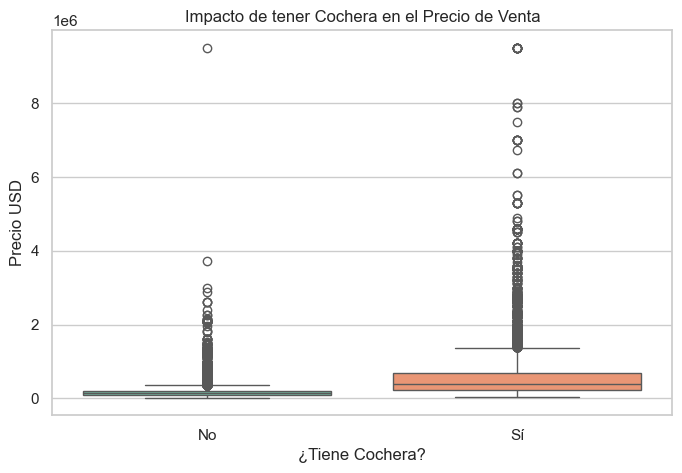

In [28]:
# Crear variable categórica para 'Tiene Cochera'
df_clean['tiene_cochera'] = df_clean['cocheras'].apply(lambda x: 'Sí' if x > 0 else 'No')

# Visualización: Precio vs Cochera
plt.figure(figsize=(8, 5))
sns.boxplot(x='tiene_cochera', y='precio_usd', data=df_clean, palette='Set2', hue='tiene_cochera')
plt.title('Impacto de tener Cochera en el Precio de Venta')
plt.ylabel('Precio USD')
plt.xlabel('¿Tiene Cochera?')
plt.show()


### 3.5 Matriz de Correlación
Analizamos la relación lineal entre las variables numéricas.

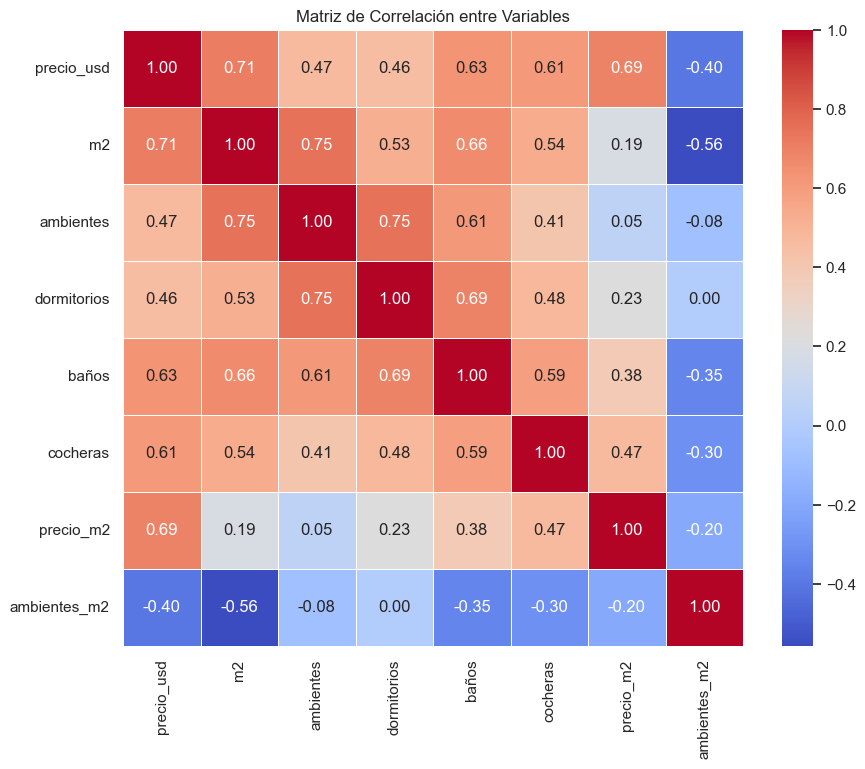

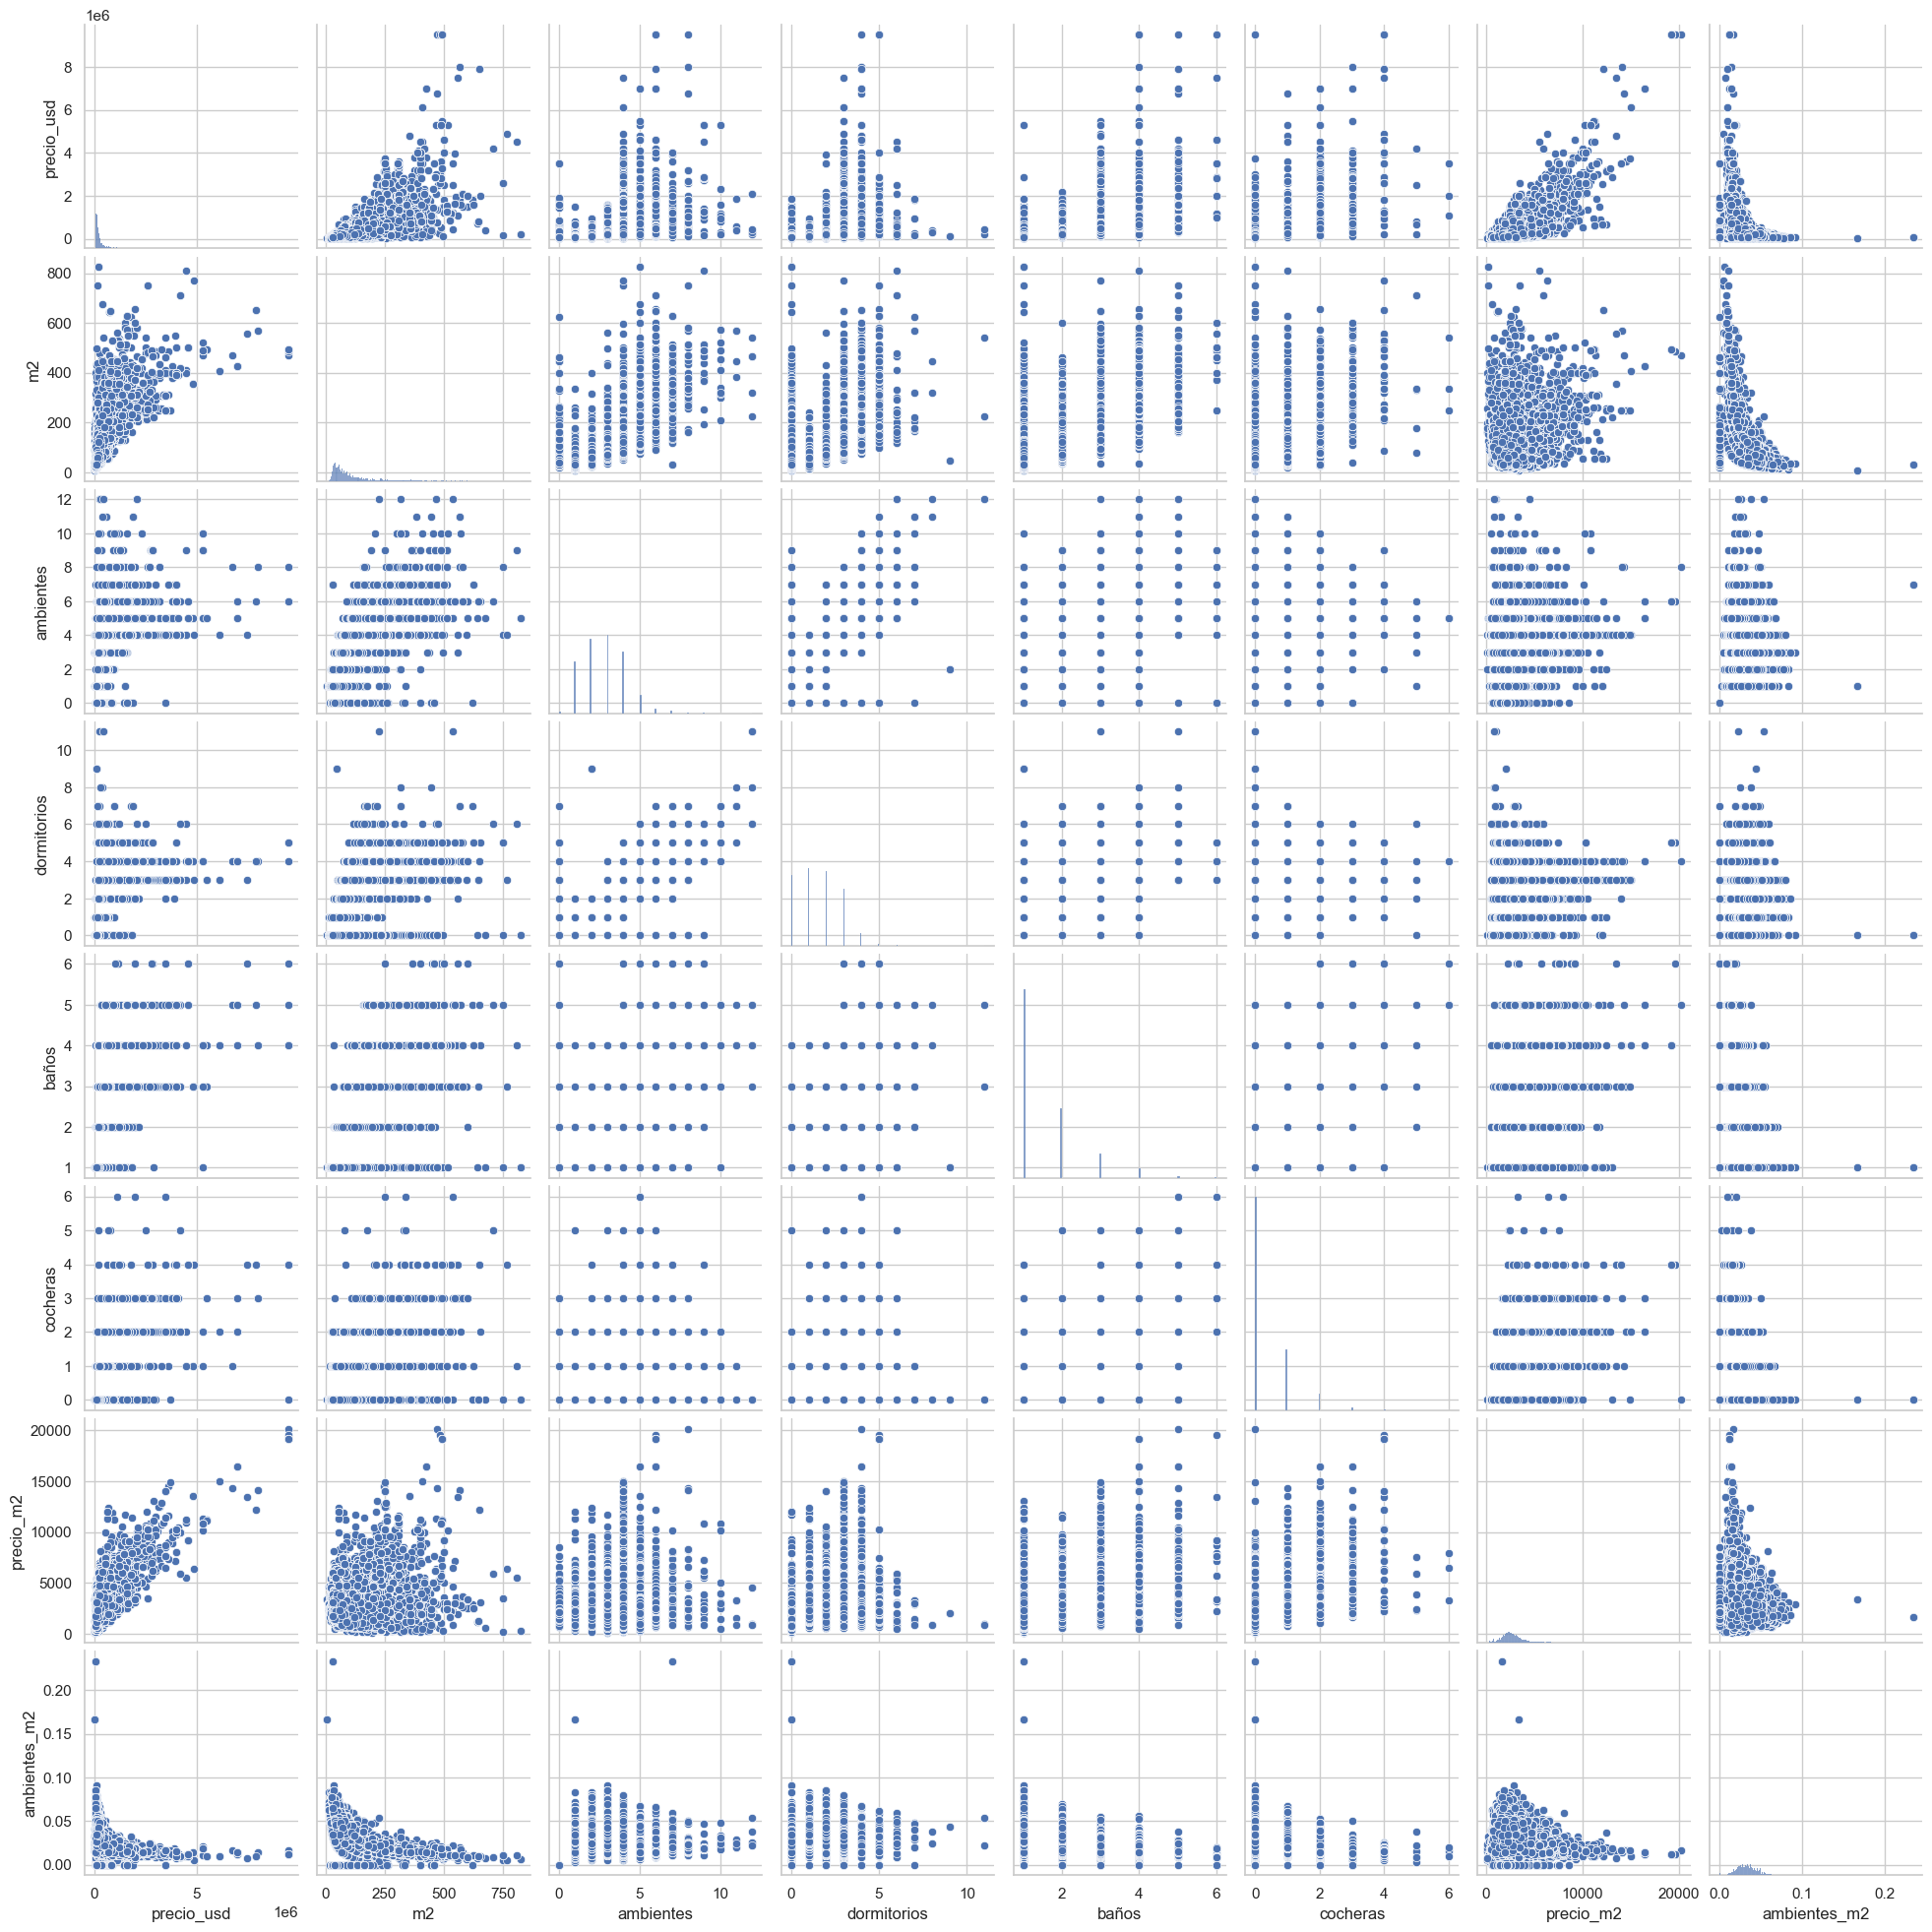

In [29]:
# Seleccionamos variables numéricas relevantes
vars_corr = ['precio_usd', 'm2', 'ambientes', 'dormitorios', 'baños', 'cocheras', 'precio_m2','ambientes_m2']
corr_matrix = df_clean[vars_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación entre Variables')
plt.show()

# Relaciones entre variables numéricas
sns.pairplot(df_clean)

## 4. Regresiones Lineales
Predicción del precio de una propiedad utilizando regresiones lineales

### Regresiones Lineales Simples

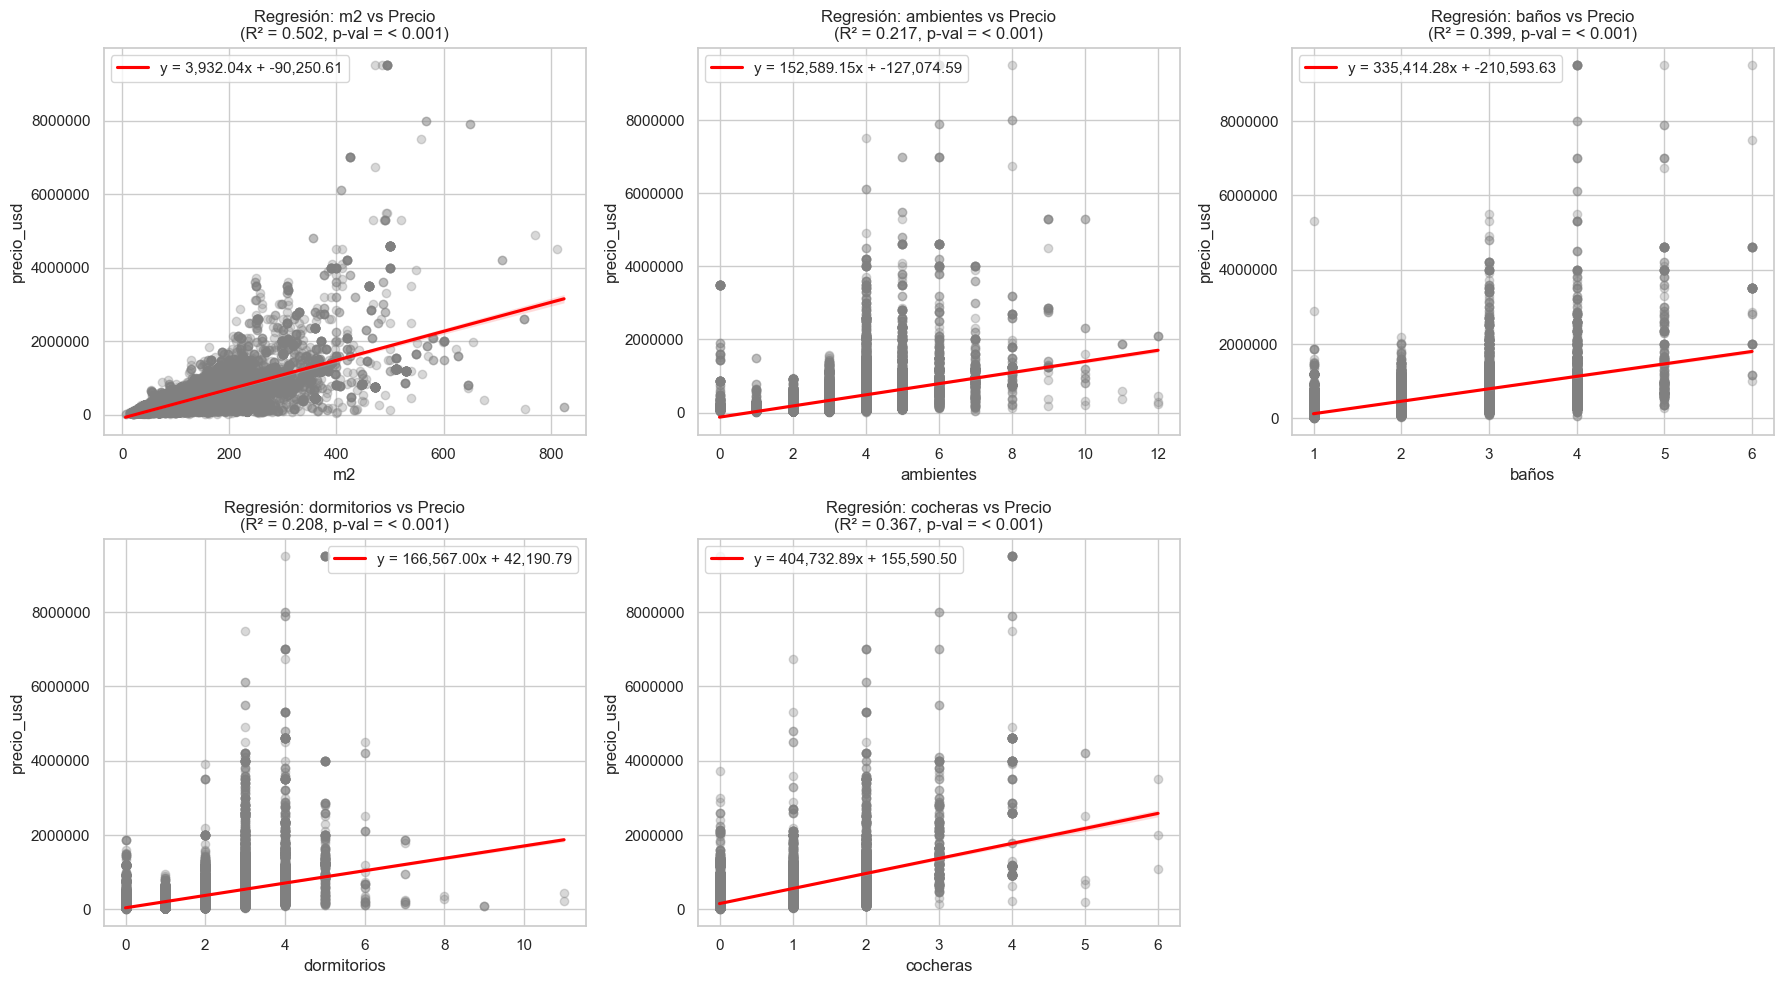

In [30]:
# Regresion Lineal Simple con R2 y p-value
variables = ['m2', 'ambientes', 'baños', 'dormitorios', 'cocheras']
target = 'precio_usd'

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(variables):
    X_simple = sm.add_constant(df_clean[[var]])
    y = df_clean[target]
    
    model_simple = sm.OLS(y, X_simple).fit()
    
    intercepto = model_simple.params['const']
    pendiente = model_simple.params[var]
    r2 = model_simple.rsquared
    
    p_valor = model_simple.pvalues[var]
    
    p_texto = f"{p_valor:.3f}" if p_valor >= 0.001 else "< 0.001"
    
    sns.regplot(ax=axes[i], x=var, y=target, data=df_clean, 
                scatter_kws={'alpha':0.3, 'color':'gray'}, 
                line_kws={'color':'red', 'label':f'y = {pendiente:,.2f}x + {intercepto:,.2f}'})
    
    axes[i].set_title(f'Regresión: {var} vs Precio\n(R² = {r2:.3f}, p-val = {p_texto})')
    axes[i].legend()
    axes[i].ticklabel_format(style='plain', axis='y') 

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()


## 5. Regresiones Lineales Multiples 
Predicción del precio de una propiedad utiliando regresiones lineales multiples

### Regresion lineal multiple Log-Lin

#### Sin Variables Dummies

In [31]:
# 1. Transformación Logarítmica (Soluciona Heterocedasticidad)
df_clean['log_precio'] = np.log(df_clean['precio_usd'])

# 2. Selección de variables
features = ['m2', 'baños', 'ambientes', 'cocheras']
X = df_clean[features]
X = sm.add_constant(X)

# 3. Verificación de VIF 
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print("Factores de Inflación de la Varianza (VIF):")
print(vif_data)

# 4. Ajuste del Modelo Múltiple
modelo_log_sin_dummies= sm.OLS(df_clean['log_precio'], X).fit()

# 5. Resumen con Errores Estándar Robustos 
print(modelo_log_sin_dummies.get_robustcov_results(cov_type='HC3').summary())

Factores de Inflación de la Varianza (VIF):
     feature  VIF
0      const 6.73
1         m2 2.84
2      baños 2.21
3  ambientes 2.43
4   cocheras 1.64
                            OLS Regression Results                            
Dep. Variable:             log_precio   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                 1.345e+04
Date:                Wed, 21 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:49:13   Log-Likelihood:                -21946.
No. Observations:               37102   AIC:                         4.390e+04
Df Residuals:                   37097   BIC:                         4.394e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|    

#### Con Varibles Dummies


In [32]:
# 1. Transformación Logarítmica (Soluciona Heterocedasticidad)
df_clean['log_precio'] = np.log(df_clean['precio_usd'])

# 2. Filtrar barrios con muy pocas observaciones (< 5) para evitar errores numéricos
conteo_barrios = df_clean['barrio'].value_counts()
barrios_a_eliminar = conteo_barrios[conteo_barrios < 5].index
print(f"Eliminando barrios con pocas observaciones: {list(barrios_a_eliminar)}")
df_clean = df_clean[~df_clean['barrio'].isin(barrios_a_eliminar)].copy()

# 3. Selección de variables y creación de variables dummy para 'barrio'
barrios_dummies = pd.get_dummies(df_clean['barrio'], prefix='barrio', drop_first=True)
barrio_referencia = sorted(df_clean['barrio'].unique())[0]
print(f"El barrio eliminado (referencia para la regresión) es: {barrio_referencia}")
features = ['m2', 'baños', 'ambientes', 'cocheras']
X = pd.concat([df_clean[features], barrios_dummies], axis=1).astype(float)
X = sm.add_constant(X)

# 4. Verificación de VIF 
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print("Factores de Inflación de la Varianza (VIF):")
print(vif_data)

# 5. Ajuste del Modelo Múltiple
modelo_log_con_dummies = sm.OLS(df_clean['log_precio'], X).fit()

# 6. Resumen con Errores Estándar Robustos 
print(modelo_log_con_dummies.get_robustcov_results(cov_type='HC3').summary())

Eliminando barrios con pocas observaciones: ['Puerto Retiro', 'Primera Junta', 'Catalinas']
El barrio eliminado (referencia para la regresión) es: Abasto
Factores de Inflación de la Varianza (VIF):
                    feature    VIF
0                     const 704.89
1                        m2   3.00
2                     baños   2.27
3                 ambientes   2.55
4                  cocheras   1.76
..                      ...    ...
76        barrio_Villa Real   1.09
77  barrio_Villa Santa Rita   3.52
78     barrio_Villa Soldati   1.15
79     barrio_Villa Urquiza  27.29
80  barrio_Villa del Parque  12.62

[81 rows x 2 columns]
                            OLS Regression Results                            
Dep. Variable:             log_precio   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     1546.
Date:                Wed, 21 Jan 2026   Pro

### Predicción

Mean Absolute Error: 58340.25937223678
R2 Score: 0.8796677950393464


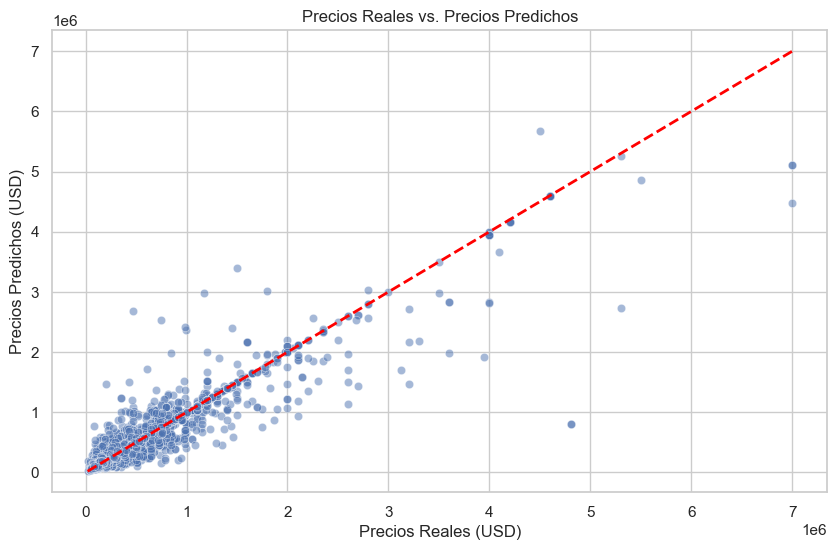

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Seleccionar variables numéricas para el modelo
X = df_clean[['m2', 'baños', 'ambientes', 'cocheras']]
y = df_clean['precio_usd']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = rf_model.predict(X_test)

# Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')
plt.xlabel('Precios Reales (USD)')
plt.ylabel('Precios Predichos (USD)')
plt.title('Precios Reales vs. Precios Predichos')
plt.show()


## 6. Verificación y Mejora del Modelo de Regresión Lineal
Nos enfocaremos en validar los supuestos de la regresión lineal para asegurar que las conclusiones sean válidas.

### Residuos y normalidad

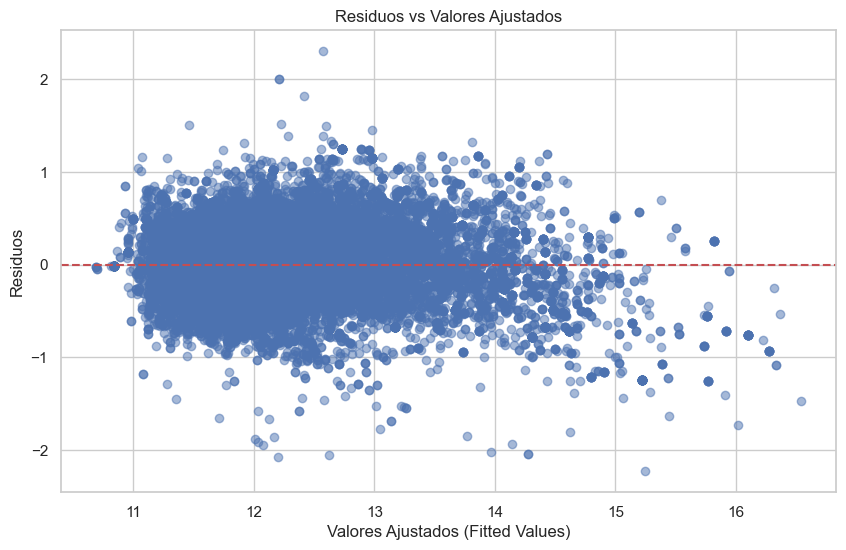

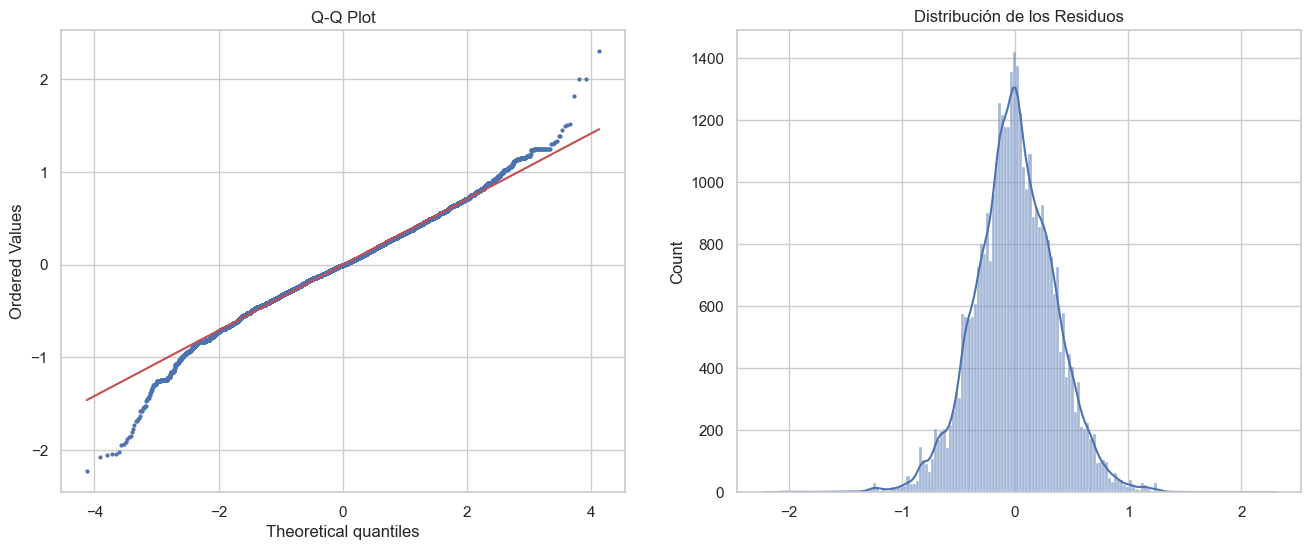

In [34]:
# Recalcular residuos y valores ajustados del modelo OLS (modelo_log_con_dummies)
model = modelo_log_con_dummies
residuals = model.resid
fitted_values = model.fittedvalues

# 1. Residuals vs Fitted (Homocedasticidad y Linealidad)
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Ajustados (Fitted Values)')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Ajustados')
plt.show()

# 2. Verificación de Normalidad (Q-Q Plot e Histograma)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

stats.probplot(residuals, dist="norm", plot=ax[0])
ax[0].get_lines()[0].set_marker('o')
ax[0].get_lines()[0].set_markersize(2.0)
ax[0].set_title('Q-Q Plot')

sns.histplot(residuals, kde=True, ax=ax[1])
ax[1].set_title('Distribución de los Residuos')

plt.show()

### Regularización (Ridge & Lasso)


In [35]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# Ridge Regression
ridge = Ridge()
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2')
ridge_cv.fit(X, y)

print("Mejor alpha para Ridge:", ridge_cv.best_params_)
print("Mejor R2 para Ridge:", ridge_cv.best_score_)

# Lasso Regression
lasso = Lasso()
# Usamos alphas pequeños porque Lasso puede llevar coeficientes a cero
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2')
lasso_cv.fit(X, y)

print("Mejor alpha para Lasso:", lasso_cv.best_params_)
print("Mejor R2 para Lasso:", lasso_cv.best_score_)


Mejor alpha para Ridge: {'alpha': 100}
Mejor R2 para Ridge: 0.5626476172883039
Mejor alpha para Lasso: {'alpha': 0.0001}
Mejor R2 para Lasso: 0.5626154875609167


### Validación Cruzada 

In [36]:
from sklearn.model_selection import cross_val_score

# Usamos el mejor estimador de Ridge encontrado anteriormente
best_model = ridge_cv.best_estimator_

# Cross-Validation para R2
cv_scores = cross_val_score(best_model, X, y, cv=10, scoring='r2')

print("Resultados de Validación Cruzada (R2):")
print(cv_scores)
print(f"R2 Promedio: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

# Cross-Validation para MAE (negativo en sklearn)
cv_mae = cross_val_score(best_model, X, y, cv=10, scoring='neg_mean_absolute_error')
print(f"MAE Promedio: {-np.mean(cv_mae):.4f}")

Resultados de Validación Cruzada (R2):
[0.55277747 0.58129417 0.59093412 0.65941907 0.61622128 0.51109191
 0.39420961 0.567476   0.72669115 0.54802283]
R2 Promedio: 0.5748 (+/- 0.0838)
MAE Promedio: 127818.8071
